### Predict term deposit for customers

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost as ctb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_auc_score, plot_confusion_matrix
file="bank-additional-full.csv"

In [166]:
df=pd.read_csv(file,  delimiter=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [167]:
df.rename(columns={'y':'bought_term_deposit', 'emp.var.rate': 'emp_var_rate', 'cons.price.idx':'cons_price_index', 'nr.employed': 'emp_count' }, inplace=True)

There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 

In [168]:
df.replace('unknown', np.nan, inplace=True)

In [169]:
df.shape

(41188, 21)

In [170]:
df.isnull().sum().sort_values(ascending=False)*100/df.shape[0]

default                20.872584
education               4.202680
housing                 2.403613
loan                    2.403613
job                     0.801204
marital                 0.194231
bought_term_deposit     0.000000
day_of_week             0.000000
contact                 0.000000
month                   0.000000
duration                0.000000
emp_count               0.000000
campaign                0.000000
pdays                   0.000000
previous                0.000000
poutcome                0.000000
emp_var_rate            0.000000
cons_price_index        0.000000
cons.conf.idx           0.000000
euribor3m               0.000000
age                     0.000000
dtype: float64

In [171]:
cat=[]
for i in df.columns:    
    if df[i].dtype == 'O':
        cat.append(i)
cat

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'bought_term_deposit']

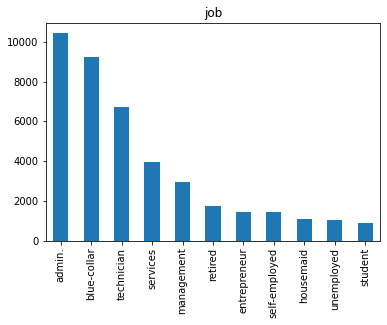

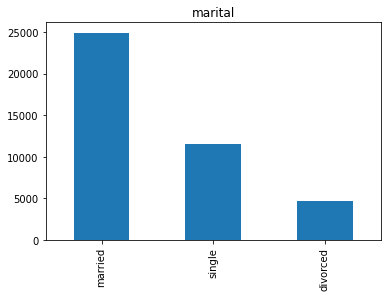

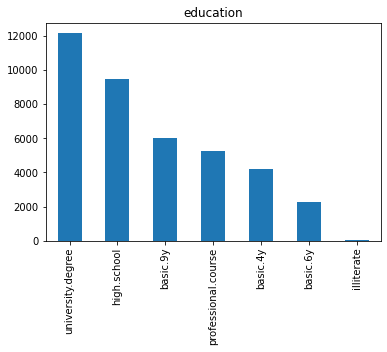

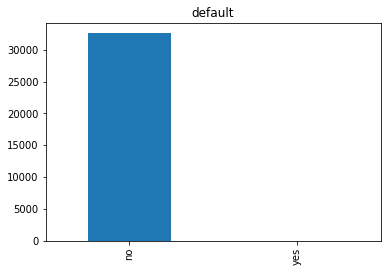

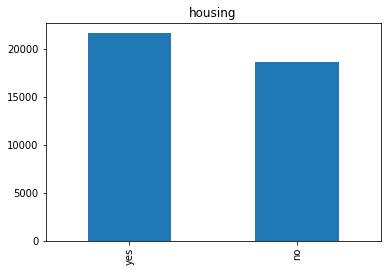

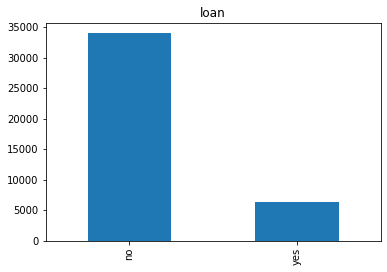

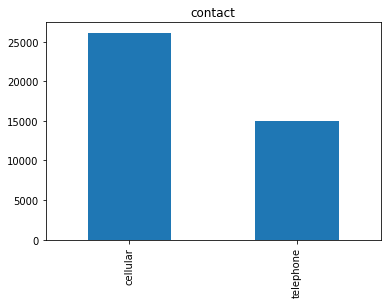

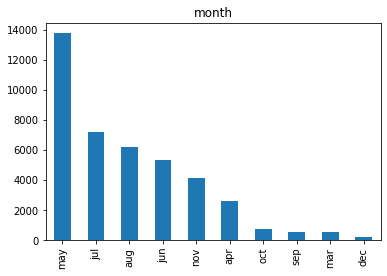

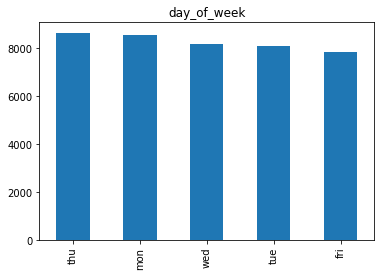

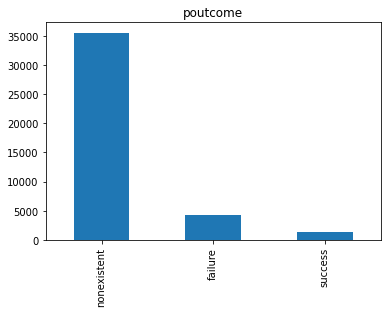

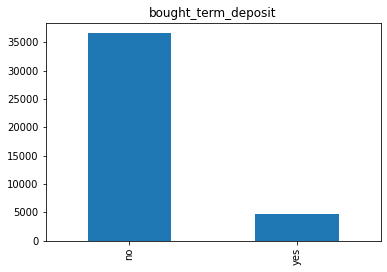

In [172]:
for i in cat:
    df[i].value_counts().plot(kind="bar")
    plt.title(i)
    plt.show()

In [173]:
df[cat]

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,bought_term_deposit
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,no
1,services,married,high.school,NaN,no,no,telephone,may,mon,nonexistent,no
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,no
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,no
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent,yes
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent,no
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,nonexistent,no
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,nonexistent,yes


In [174]:
df.drop('default', axis=1,inplace=True)
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(41188, 20)
(38245, 20)


In [175]:
cat.remove('default')
cat

['job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome',
 'bought_term_deposit']

Get cardinality and applying label encoding to only those columns that have cardinality of <=3

In [176]:
for i in cat:
    print(len(df[i].unique()), i)

11 job
3 marital
7 education
2 housing
2 loan
2 contact
10 month
5 day_of_week
3 poutcome
2 bought_term_deposit


marital, housing, loan, contact, poutcome, bought_term_deposit have cardinality of <=3

In [181]:
from sklearn.preprocessing import LabelEncoder
cat3=['marital', 'housing', 'loan', 'contact', 'poutcome', 'bought_term_deposit']
le = LabelEncoder() 
df[cat3] = df[cat3].apply(lambda x: le.fit_transform(x))
df.head(6)

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_index,cons.conf.idx,euribor3m,emp_count,bought_term_deposit
0,56,housemaid,1,basic.4y,0,0,1,may,mon,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,1,high.school,0,0,1,may,mon,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,1,high.school,1,0,1,may,mon,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,1,basic.6y,0,0,1,may,mon,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,1,high.school,0,1,1,may,mon,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
5,45,services,1,basic.9y,0,0,1,may,mon,198,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


Encoding ordinal category data

In [182]:
df.day_of_week.replace(to_replace=['mon', 'tue', 'wed', 'thu', 'fri'],value=[1,2,3,4,5] , inplace=True)
df.month.replace(to_replace=['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],value=[3,4,5, 6,7,8, 9,10, 11, 12] , inplace=True)
df.education.replace(to_replace=['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree' ], value=[1,2,3,4,5, 6, 7] , inplace=True)

Using one hot encoder for job level as cardinality is high

In [190]:
job = pd.get_dummies(df.job, prefix_sep='_', drop_first=True)
df=pd.concat([df, job], axis=1)
df.drop('job', axis=1, inplace=True)
df.head(3)

,age,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_index,cons.conf.idx,euribor3m,emp_count,bought_term_deposit,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,56,1,2,0,0,1,5,1,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0
1,57,1,5,0,0,1,5,1,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0
2,37,1,5,1,0,1,5,1,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0


<AxesSubplot:xlabel='bought_term_deposit', ylabel='pdays'>

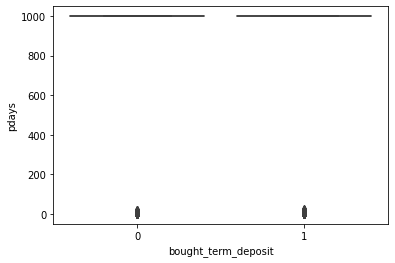

In [193]:
sns.boxplot(df.bought_term_deposit,df.pdays)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'blue-collar'}>,
        <AxesSubplot:title={'center':'bought_term_deposit'}>,
        <AxesSubplot:title={'center':'campaign'}>,
        <AxesSubplot:title={'center':'cons.conf.idx'}>],
       [<AxesSubplot:title={'center':'cons_price_index'}>,
        <AxesSubplot:title={'center':'contact'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'education'}>],
       [<AxesSubplot:title={'center':'emp_count'}>,
        <AxesSubplot:title={'center':'emp_var_rate'}>,
        <AxesSubplot:title={'center':'entrepreneur'}>,
        <AxesSubplot:title={'center':'euribor3m'}>,
        <AxesSubplot:title={'center':'housemaid'}>],
       [<AxesSubplot:title={'center':'housing'}>,
        <AxesSubplot:title={'center':'loan'}>,
        <AxesSubplot:title={'center':'management'}>,
        <AxesSubplot:title={'center':'marital'

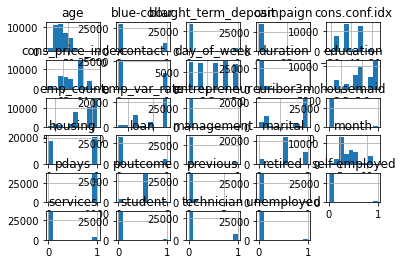

In [206]:
df.hist()

In [207]:
df.bought_term_deposit.value_counts(normalize=True)

0    0.888665
1    0.111335
Name: bought_term_deposit, dtype: float64

<AxesSubplot:>

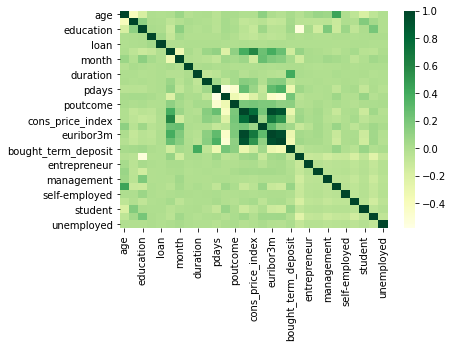

In [191]:
sns.heatmap(df.corr(), cmap="YlGn")

In [199]:
df.columns

Index(['age', 'marital', 'education', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp_var_rate', 'cons_price_index', 'cons.conf.idx', 'euribor3m',
       'emp_count', 'bought_term_deposit', 'blue-collar', 'entrepreneur',
       'housemaid', 'management', 'retired', 'self-employed', 'services',
       'student', 'technician', 'unemployed'],
      dtype='object')

In [202]:
X=df[['age', 'marital', 'education', 'housing', 'loan', 'contact', 'month','day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp_var_rate', 'cons_price_index', 'cons.conf.idx', 'euribor3m', 'emp_count', 'blue-collar', 'entrepreneur',
       'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed']]
y=df.bought_term_deposit
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=42, stratify=y)

In [213]:
lr=LogisticRegression(solver='liblinear', class_weight="balanced")  #'liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'
lr.fit(X_train, y_train)
yhat=lr.predict(X_test)
print(accuracy_score(y_test, yhat ))
print(f1_score(y_test, yhat, average='weighted' ))
print(confusion_matrix(y_test, yhat ))

0.856201631457854
0.8754420814376952
[[7273 1224]
 [ 151  914]]


In [214]:
svm_model=SVC(kernel='linear', class_weight="balanced")  
svm_model.fit(X_train, y_train)
yhat=svm_model.predict(X_test)
print(accuracy_score(y_test, yhat ))
print(f1_score(y_test, yhat, average='weighted' ))
print(confusion_matrix(y_test, yhat ))

0.883288015059611
0.8914517769534301
[[7728  769]
 [ 347  718]]


0.84197866555114
0.8659031124553005
[[7061 1436]
 [  75  990]]
0.8802883204842803


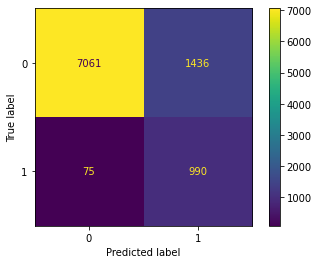

In [240]:
dt=DecisionTreeClassifier(max_depth=6, class_weight="balanced", criterion='entropy' )  
dt.fit(X_train, y_train)
yhat=dt.predict(X_test)
print(accuracy_score(y_test, yhat ))
print(f1_score(y_test, yhat, average='weighted' ))
print(confusion_matrix(y_test, yhat ))
print(roc_auc_score(y_test, yhat ))
print(plot_confusion_matrix(dt, X_test, y_test))

0.8384229240744614
0.862102626221342
[[7088 1409]
 [ 136  929]]
0.8532386188773613


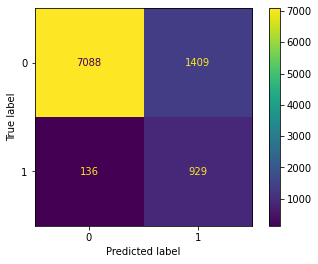

In [230]:
rt=RandomForestClassifier(max_depth=4, class_weight="balanced", criterion='entropy', )  
rt.fit(X_train, y_train)
yhat=rt.predict(X_test)
print(accuracy_score(y_test, yhat ))
print(f1_score(y_test, yhat, average='weighted' ))
print(confusion_matrix(y_test, yhat ))
print(roc_auc_score(y_test, yhat ))
print(plot_confusion_matrix(rt, X_test, y_test))

0.8880987241162936
0.9004875388229153
[[7568  929]
 [ 141  924]]
0.9464952833394388


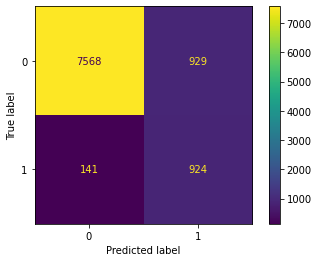

In [254]:
xg_model=xgb.XGBRFClassifier(max_depth=12, scale_pos_weight=9, n_estimators=1200)  #0s/1s
xg_model.fit(X_train, y_train) 
yhat=xg_model.predict(X_test)
print(accuracy_score(y_test, yhat ))
print(f1_score(y_test, yhat, average='weighted' ))
print(confusion_matrix(y_test, yhat ))
print(plot_confusion_matrix(xg_model, X_test, y_test))
print(roc_auc_score(y_test, xg_model.predict_proba(X_test)[:,1]))

0.8978247228613261
0.9073074360963334
[[7703  794]
 [ 183  882]]
0.9467279531411528


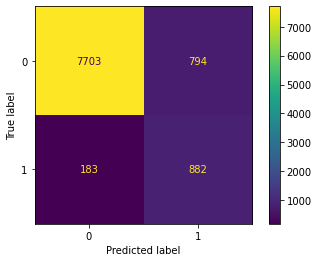

In [259]:
cat_model=ctb.CatBoostClassifier(max_depth=10, scale_pos_weight=9, n_estimators=1000)  #0s/1s
cat_model.fit(X_train, y_train, verbose=False) 
yhat=cat_model.predict(X_test)
print(accuracy_score(y_test, yhat ))
print(f1_score(y_test, yhat, average='weighted' ))
print(confusion_matrix(y_test, yhat ))
print(plot_confusion_matrix(cat_model, X_test, y_test))
print(roc_auc_score(y_test, cat_model.predict_proba(X_test)[:,1]))

0.9039949801296799
0.9101111640634723
[[7850  647]
 [ 271  794]]
0.9454603419820639


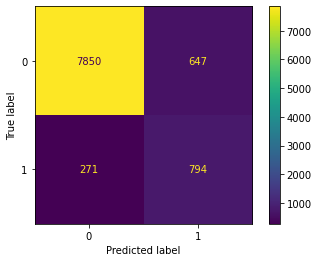

In [258]:
cat_model=ctb.CatBoostClassifier(max_depth=12, scale_pos_weight=8.5, n_estimators=1000)  #0s/1s
cat_model.fit(X_train, y_train, verbose=False) 
yhat=cat_model.predict(X_test)
print(accuracy_score(y_test, yhat ))
print(f1_score(y_test, yhat, average='weighted' ))
print(confusion_matrix(y_test, yhat ))
print(plot_confusion_matrix(cat_model, X_test, y_test))
print(roc_auc_score(y_test, cat_model.predict_proba(X_test)[:,1]))